# Importing Packages

In [405]:
import numpy as np
from numpy import linalg
from scipy import linalg as splinalg
import matplotlib.pyplot as plt
from scipy import sparse as sp
from scipy.sparse.linalg import expm_multiply
from functools import reduce
import itertools
from scipy import linalg
from scipy.linalg import expm, logm
from scipy.special import comb
from itertools import combinations_with_replacement, product
from collections import Counter
import copy
from scipy.linalg import ishermitian
import time

# Definitions

In [515]:
params = {
    'N': 10, # no. of sites
    't':1, # Hopping Amplitude
    'T': 10, # Total Time Evolution
    'tau': 0.1 # Time step
}

params['N'], params['k'] = 8, 8
params['N1'], params['N2'] = 4, 8
# params['N'], params['k'] = 4, 4
# params['N1'], params['N2'] = 2, 4

params['U'] = 0
params['mu'] = 0
params['start_site'], params['end_site'] = 0, params['N1']

params['dim'], params['truncationParam_n'] = 0, 2
params['occupationTuple_lst'] = []
params['Map_ParticleLoc_OccupNo']={}
params['map_occupToD_Dim'] = {}

def dimension(params, **kwargs):
    '''
    For k identical bosonic particles on N lattice site, 
    Changes the dim and initializes the vac state
    based on dim.
    Makes change to the params - 'dim', 'vac' within the function.
    Make sure to define the parameters list as params.
    Return: Null
    '''
    N, k, dim = params['N'], params['k'], int(params['dim']) # N = number of sites, k = no. of identical bosonic particles
    params['dim'] = int(comb(N+k-1, k)) # This is for k identical bosonic particles
    params['vac'] = sp.csc_matrix(np.zeros(N))
    pass


In [516]:
dimension(params)
params['dim']

6435

In [517]:
def normalizeWF(psi,**kwargs):
    '''
    Return a Normalized Wavefunction
    '''
    shape, dtype = psi.shape, psi.dtype
    NWF = psi
    if np.array_equal(psi, np.zeros(shape, dtype = dtype)) == True:
        NWF = psi
    elif np.vdot(psi, psi) == 0:
        NWF = psi
    else:
        NWF = psi/(np.sqrt(np.vdot(psi, psi)))
    return NWF


In [518]:
def is_unitary(matrix):
    return np.allclose(np.dot(matrix, matrix.conj().T), np.eye(matrix.shape[0])) 

# AJJ Hamiltonian

In [519]:
def creationOpMatrix(params, **kwargs):
    '''
    Returns Bosonic Creation Operator
    '''
    A = sp.diags(np.sqrt(np.arange(1, params['truncationParam_n']+1, 1)), -1)
    return A

def annihilationOpMatrix(params, **kwargs):
    '''
    Returns Bosonic Annihilation Operator
    '''
    A = sp.diags(np.sqrt(np.arange(1, params['truncationParam_n']+1, 1)), 1)
    return A

def numOpMatrix(params, site_no, **kwargs):
    '''
    Returns Bosonic Number Operator
    '''
    createOp = creationOpMatrix(params)
    nOp = createOp@createOp.transpose()
    I = sp.identity(params['truncationParam_n']+1)
    lst = [I for _ in range(params['N'])]
    if 'tilt' in kwargs:
        lst[site_no] = nOp*site_no
        matrx = sp.csc_matrix(reduce(sp.kron, lst))
        return matrx
    else: 
        lst[site_no] = nOp
        matrix1 = sp.csc_matrix(reduce(sp.kron, lst))
        lst[site_no] = nOp@nOp
        matrix2 = sp.csc_matrix(reduce(sp.kron, lst))
        return matrix1, matrix2

def HoppingOpMatrix(params, site_no, **kwargs):
    '''
    Returns Bosonic Hopping Operator
    '''
    n, N = params['truncationParam_n'], params['N']
    matrixx = sp.csc_matrix(((n+1)**N, (n+1)**N))
    if site_no != params['N']-1:
        creationOp, annihOp = creationOpMatrix(params), annihilationOpMatrix(params)
        I = sp.identity(params['truncationParam_n']+1)
        lst = [I for _ in range(params['N'])]
        lst[site_no], lst[site_no+1] = creationOp, annihOp
        matrixx = sp.csc_matrix(reduce(sp.kron, lst))
    return matrixx

In [520]:
def Prod_OccupBasis(params, **kwargs):
    '''
    Generates all combinations using product from itertools.
    Returns: valid_combinations under the k-constraint (particle
    number conservation) and all combinations.
    '''
    n, N, k = params['truncationParam_n']+1, params['N'], params['k']
    all_combinations = dict(enumerate(itertools.product(range(n), repeat=N)))
    valid_combinations = dict(filter(lambda x: sum(x[1]) == k, all_combinations.items()))
    return valid_combinations, all_combinations
# params['truncationParam_n'], params['N'], params['k'] = 2, 2, 2

def projectionMatrix(params, **kwargs):
    '''
    Creates a projection matrix whose elements are non-zero
    for the indices of the occup_states obeying k-constraint.
    '''
    valid_combinations, all_combinations = Prod_OccupBasis(params)
    rows, cols = len(valid_combinations), len(all_combinations)
    PM = sp.csc_matrix((rows, cols))
    for i, key in enumerate(list(reversed(valid_combinations.keys()))):
        PM[i, key] = 1.0
    return PM

In [521]:
def sites2_Ngk_AJJ_Hamil(params, **kwargs):
    '''
    Returns AJJ-BHM Hamiltonian Matrix and ground state
    '''
    n, N, k = params['truncationParam_n'], params['N'], params['k']
    H = sp.csc_matrix(((n+1)**N, (n+1)**N))
    PM = projectionMatrix(params)

    for i in range(params['N']):
        HopOp, nOp_mu = HoppingOpMatrix(params, i), numOpMatrix(params, i, tilt = True)
        NumOp, NumOp_2 = numOpMatrix(params, i)
        H += -params['t']*(HopOp+HopOp.transpose()) + 0.5*params['U']*(NumOp_2 - NumOp) - params['mu']*nOp_mu
        
    H = PM@H@PM.transpose()
    # return H
    eigenval, eigenvec = sp.linalg.eigsh(H, k=1, which='SA')
    return H, eigenvec

# $e^{-i\phi\hat{N}_{R_{1}}}$ Operators where $\phi = \pi$

In [522]:
def phi_Nop(params, **kwargs):
    '''
    Returns an operator of the form e^{ -i * \\phi * \\hat{N}_{R_{1}}}
    Args: params
    kwargs: phi [Required]: pass an angle.
    '''
    phi = kwargs['phi']
    diag_elements = [expm(-1j * n * phi)[0][0] for n in range(params['truncationParam_n'] + 1)]
    print(diag_elements)
    A = sp.diags(diag_elements, offsets=0)  
    return A

def parity_op(params, **kwargs):
    '''
    Returns Parity Operator
    '''
    A = sp.diags([(-1.)**n for n in range(params['truncationParam_n']+1)])
    return A

In [523]:
diag_elements = [expm(-1j * n * np.pi)[0][0] for n in range(params['truncationParam_n'] + 1)]
print(diag_elements)
A = sp.diags(diag_elements, offsets=0)  

[(1+0j), (-1-1.2246467991473532e-16j), (1+2.4492935982947064e-16j)]


In [524]:
is_unitary(A.toarray()@(A.toarray()).T)

True

In [525]:
ishermitian(A.toarray()@(A.toarray()).T)

False

In [526]:
# params['truncationParam_n'] = 2
# phi_Nop(params, phi = np.pi).toarray()

In [527]:
# phi_Nop(params, phi = np.pi).toarray()

In [528]:
def prdt_ephiN_op(params, **kwargs):
    '''
    Returns an operator of the form e^{ -i * \\phi * \\hat{N}_{R_{1}}} for a region in AJJ
    Args: params,
    kwargs: phi
    Note:
    params['start_site']: where the region is starting
    params['end_site']: where the region is ending
    for eg, if region-1 is from 0 till 29,
    then (start_site, end_site) = (0, 30).
    '''
    phi = kwargs['phi']
    A = phi_Nop(params, phi = phi)
    start_site, end_site = params['start_site'], params['end_site'] 
    createOp = creationOpMatrix(params)
    I = sp.identity(createOp.shape[0])
    lst = [I for _ in range(params['N'])]
    for i in range(start_site, end_site, 1):
        lst[i] = A
    matrixx = reduce(sp.kron, lst)
    return matrixx

In [529]:
p = prdt_ephiN_op(params, phi = np.pi).toarray()

[(1+0j), (-1-1.2246467991473532e-16j), (1+2.4492935982947064e-16j)]


In [530]:
p.shape

(6561, 6561)

In [531]:
p

array([[1.+0.00000000e+00j, 0.+0.00000000e+00j, 0.+0.00000000e+00j, ...,
        0.+0.00000000e+00j, 0.+0.00000000e+00j, 0.+0.00000000e+00j],
       [0.+0.00000000e+00j, 1.+0.00000000e+00j, 0.+0.00000000e+00j, ...,
        0.+0.00000000e+00j, 0.+0.00000000e+00j, 0.+0.00000000e+00j],
       [0.+0.00000000e+00j, 0.+0.00000000e+00j, 1.+0.00000000e+00j, ...,
        0.+0.00000000e+00j, 0.+0.00000000e+00j, 0.+0.00000000e+00j],
       ...,
       [0.+0.00000000e+00j, 0.+0.00000000e+00j, 0.+0.00000000e+00j, ...,
        1.+9.79717439e-16j, 0.+0.00000000e+00j, 0.+0.00000000e+00j],
       [0.+0.00000000e+00j, 0.+0.00000000e+00j, 0.+0.00000000e+00j, ...,
        0.+0.00000000e+00j, 1.+9.79717439e-16j, 0.+0.00000000e+00j],
       [0.+0.00000000e+00j, 0.+0.00000000e+00j, 0.+0.00000000e+00j, ...,
        0.+0.00000000e+00j, 0.+0.00000000e+00j, 1.+9.79717439e-16j]])

In [532]:
ishermitian(np.real(p))

True

In [533]:
is_unitary(p)

True

In [534]:
def prdt_parity_op(params, **kwargs):
    '''
    Returns Parity Operator for a region in AJJ
    Args: params,

    Note:
    params['start_site']: where the region is starting
    params['end_site']: where the region is ending
    for eg, if region-1 is from 0 till 29,
    then (start_site, end_site) = (0, 30).
    '''
    A = parity_op(params)
    start_site, end_site = params['start_site'], params['end_site'] 
    createOp = creationOpMatrix(params)
    I = sp.identity(createOp.shape[0])
    lst = [I for _ in range(params['N'])]
    for i in range(start_site, end_site, 1):
        lst[i] = A
    matrixx = reduce(sp.kron, lst)
    return matrixx

# <font>Applying $\ket{\psi^{\prime}} = e^{ -i \phi \hat{N}_{R_{1}}}\ket{\psi}$</font>

In [535]:
# def generate_psiPrime(params, **kwargs):
#     '''
#     Returns wavefunction when Parity Operator for a region is applied on WFn.
#     kwargs: start_site, end_site, eigenvec [Required].
#     eigenvec: Ground state of AJJ.
#     For \\phi != \\pi - pass optional argument phi to apply phase-changing operator with a phase of \\phi other than \\pi.
#     '''
#     PM = projectionMatrix(params)
#     if 'phi' in kwargs:
#         matrixx = PM@prdt_ephiN_op(params, phi = kwargs['phi'])@PM.transpose()
#     else:
#         matrixx = PM@prdt_parity_op(params)@PM.transpose()
#     wfn = matrixx@kwargs['eigenvec']
#     return normalizeWF(wfn)

In [536]:
def generate_psiPrime(params, **kwargs):
    '''
    Returns wavefunction when Parity Operator for a region is applied on WFn.
    kwargs: start_site, end_site, eigenvec [Required].
    eigenvec: Ground state of AJJ.
    '''
    PM = projectionMatrix(params)
    matrixx = PM@prdt_parity_op(params)@PM.transpose()
    wfn = matrixx@kwargs['eigenvec']
    return wfn

In [537]:
H, eigenvec = sites2_Ngk_AJJ_Hamil(params)
# H = sites2_Ngk_AJJ_Hamil(params)

D:\AnacondaFinal\anacondaInstall\envs\WalshPulseSeq\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [538]:
H.shape

(1107, 1107)

In [539]:
psi_prime = generate_psiPrime(params, eigenvec = eigenvec, phi = np.pi)

In [540]:
psi_prime.shape

(1107, 1)

In [541]:
psi_prime.T@psi_prime

array([[1.]])

In [542]:
for i, j in zip(eigenvec, psi_prime):
    print(i, j)

[6.87224642e-06] [6.87224642e-06]
[5.66237917e-05] [-5.66237917e-05]
[0.00012188] [-0.00012188]
[0.00015396] [-0.00015396]
[0.00010951] [-0.00010951]
[0.00010738] [0.00010738]
[0.00032737] [0.00032737]
[0.00041971] [0.00041971]
[0.00030104] [0.00030104]
[0.00038405] [0.00038405]
[0.00066244] [0.00066244]
[0.00047108] [0.00047108]
[0.00052471] [0.00052471]
[0.00050975] [0.00050975]
[0.00024173] [0.00024173]
[0.00018817] [-0.00018817]
[0.0004411] [-0.0004411]
[0.00057143] [-0.00057143]
[0.00041052] [-0.00041052]
[0.0005008] [0.0005008]
[0.00182295] [0.00182295]
[0.0024366] [0.0024366]
[0.00177308] [0.00177308]
[0.00217458] [0.00217458]
[0.00391953] [0.00391953]
[0.00283972] [0.00283972]
[0.00315112] [0.00315112]
[0.00310052] [0.00310052]
[0.00148199] [0.00148199]
[0.00208925] [-0.00208925]
[0.00311021] [-0.00311021]
[0.00232831] [-0.00232831]
[0.00299019] [-0.00299019]
[0.00642891] [-0.00642891]
[0.00490759] [-0.00490759]
[0.00517953] [-0.00517953]
[0.00526129] [-0.00526129]
[0.00254058]

In [543]:
np.array_equal(psi_prime, eigenvec)

False

# <font>Time Evolution of $\ket{\psi^{\prime}}$:: $\ket{\psi(t)} = e^{-i\cdot t \cdot H_{AJJ}}\ket{\psi^{\prime}}$</font>

In [544]:
# def time_evolutionPsiPrime(params, **kwargs):
#     '''
#     Returns a list of time evolved wavefunctions obtained after the application of Parity Operator of a region 
#     for time 0 to T with time step 'tau'.
#     This is done wrt the AJJ Hamiltonian.
#     kwargs: start_site, end_site, eigenvec, H [Required].
#     H: Hamiltonian of AJJ.
#     eigenvec: Ground state of AJJ.
#     For \\phi != \\pi - pass optional argument phi to apply phase-changing operator with a phase of \\phi other than \\pi.
#     '''
#     H, eigenvec = kwargs['H'], kwargs['eigenvec']
#     if 'phi' in kwargs:
#         wfn = generate_psiPrime(params, eigenvec = eigenvec, phi = kwargs['phi'])
#     else:
#         wfn = generate_psiPrime(params, eigenvec = eigenvec)
#     time_list = np.arange(0, params['T'], params['tau'])
#     unitary_timeOp = [expm(-1j*t*(H.toarray())) for t in time_list]
#     psi_t = [normalizeWF(uOp@wfn) for uOp in unitary_timeOp]
#     return psi_t

In [545]:
def time_evolutionPsiPrime(params, **kwargs):
    '''
    Returns a list of time evolved wavefunctions obtained after the application of Parity Operator of a region 
    for time 0 to T with time step 'tau'.
    This is done wrt the AJJ Hamiltonian.
    kwargs: start_site, end_site, eigenvec, H [Required].
    H: Hamiltonian of AJJ.
    eigenvec: Ground state of AJJ.
    '''
    H, eigenvec = kwargs['H'], kwargs['eigenvec']
    H_array = H.toarray()
    print(ishermitian(H_array))
    wfn = generate_psiPrime(params, eigenvec = eigenvec)
    print(type(wfn))
    time_list = np.arange(0, params['T'], params['tau'])
    # unitary_timeOp = [expm(-1j*t*H_array) for t in time_list]
    # psi_t = [normalizeWF(uOp@wfn) for uOp in unitary_timeOp]
    # psi_t = [expm_multiply(-1j*t*H, wfn) for t in time_list]
    psi_t  = []
    for t in time_list:
        wfn_t = expm_multiply(-1j*t*H, wfn)
        norm = np.sqrt(np.vdot(wfn_t, wfn_t))
        # print(norm)
        # norm2 = np.vdot(wfn_t, wfn_t)
        # print(f'norm2 = {norm2}')
        # norm3 = np.abs(wfn_t.T.conj()@wfn_t)
        # print(f'norm3 = {norm3}')
        psi_t.append(wfn_t/norm)
    return psi_t

In [546]:
start_time = time.time()


psi_t = time_evolutionPsiPrime(params, H = H, eigenvec = eigenvec, phi = np.pi)


end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

True
<class 'numpy.ndarray'>
Elapsed time: 8.460547685623169 seconds


In [547]:
psi_t

[array([[ 6.87224642e-06+0.j],
        [-5.66237917e-05+0.j],
        [-1.21875403e-04+0.j],
        ...,
        [-1.88172197e-04+0.j],
        [-5.66237917e-05+0.j],
        [ 6.87224642e-06+0.j]]),
 array([[ 9.46723320e-06-8.00764735e-06j],
        [-5.56894149e-05-3.95550055e-05j],
        [-1.29298207e-04-8.91176897e-05j],
        ...,
        [-2.30961873e-04-4.59141634e-05j],
        [-5.56894149e-05-3.95550055e-05j],
        [ 9.46723320e-06-8.00764735e-06j]]),
 array([[ 1.92429783e-05-1.45503418e-05j],
        [-2.83534934e-05-1.02316795e-04j],
        [-1.06421332e-04-2.35630956e-04j],
        ...,
        [-2.72119740e-04-2.19648715e-04j],
        [-2.83534934e-05-1.02316795e-04j],
        [ 1.92429783e-05-1.45503418e-05j]]),
 array([[ 3.82801927e-05-1.25007029e-05j],
        [ 7.23265928e-05-1.60054164e-04j],
        [ 4.77104045e-05-4.14321337e-04j],
        ...,
        [-1.15267254e-04-4.95745775e-04j],
        [ 7.23265928e-05-1.60054164e-04j],
        [ 3.82801927e-05-

In [548]:
for i, psi in enumerate(psi_t):
    norm = psi.T@psi
    # print(f'i={i}, norm={np.linalg.norm(psi.T)}')
    print(f'i={i}, norm={np.abs(norm)}')
    # if norm != 1:
    #     print(i)

i=0, norm=[[1.]]
i=1, norm=[[0.96397568]]
i=2, norm=[[0.86904727]]
i=3, norm=[[0.74661121]]
i=4, norm=[[0.62902385]]
i=5, norm=[[0.53553539]]
i=6, norm=[[0.46905416]]
i=7, norm=[[0.42271702]]
i=8, norm=[[0.3879956]]
i=9, norm=[[0.35896005]]
i=10, norm=[[0.33369306]]
i=11, norm=[[0.31357287]]
i=12, norm=[[0.30051019]]
i=13, norm=[[0.29502709]]
i=14, norm=[[0.29748982]]
i=15, norm=[[0.30959323]]
i=16, norm=[[0.33324795]]
i=17, norm=[[0.36857594]]
i=18, norm=[[0.41316395]]
i=19, norm=[[0.46233507]]
i=20, norm=[[0.50908177]]
i=21, norm=[[0.54391886]]
i=22, norm=[[0.55704386]]
i=23, norm=[[0.54263339]]
i=24, norm=[[0.50183544]]
i=25, norm=[[0.44222972]]
i=26, norm=[[0.37444926]]
i=27, norm=[[0.30862407]]
i=28, norm=[[0.25261248]]
i=29, norm=[[0.21119999]]
i=30, norm=[[0.18491301]]
i=31, norm=[[0.16938493]]
i=32, norm=[[0.15760169]]
i=33, norm=[[0.14488478]]
i=34, norm=[[0.13263649]]
i=35, norm=[[0.12771162]]
i=36, norm=[[0.13664185]]
i=37, norm=[[0.15820824]]
i=38, norm=[[0.183883]]
i=39, n

# <font>$\hat{N}_{R_{j}} = \sum_{i \in R_{j}} n_{i}$ where $j \in {1, 2, 3}$</font>

In [549]:
def N_op(params, region_number, **kwargs):
    '''
    Returns N operator = sum of n_{i} where i belongs to a region.
    Args: params,
    region_number (integer): takes 1, 2, 3 where 1, 3 correspond to SF regions in SF-MIP-SF AJJ config and 2 - MIP region.
    '''
    PM = projectionMatrix(params)
    # print(f'PM = {PM.shape}')
    createOp = creationOpMatrix(params)
    nOp = createOp@createOp.transpose()
    if region_number == 3:
        start, end = params['N2'], params['N3']
    elif region_number == 2:
        start, end =  params['N1'], params['N2']
    elif region_number == 1:
        start, end = 0, params['N1']
    I = sp.identity(createOp.shape[0])
    lst = [I for _ in range(params['N'])]
    matrixx = PM@(sp.csc_matrix((createOp.shape[0]**params['N'], createOp.shape[0]**params['N'])))@PM.transpose()
    # matrixx = sp.csc_matrix((createOp.shape[0]**params['N'], createOp.shape[0]**params['N']))
    for i in range(start, end):
        lst[i] = nOp
        matrixx += (PM@reduce(sp.kron, lst)@PM.transpose())
        # matrixx += reduce(sp.kron, lst)
        lst[i] = I

    # matrixx = PM@matrixx@PM.transpose()
    # print(f'matrixx={matrixx.shape}')
    return matrixx 

# <font>Plot of $|\bra{\psi(t)} N_{R_{1}} - N_{R_{3}}\ket{\psi(t)}|$ vs Time</font>

In [550]:
def N1_minusN2_exp(params, **kwargs):
    '''
    Returns the list of expectation values of N1@N2, N1 - N2 operators wrt the time evolved psi-prime for different final times.
    kwargs: psi_t [Optional] - if passed, function uses this else uses the one generated from functn 'time_evolutionPsiPrime'
    phi [Optional]: Pass it to create a phase difference of \\phi other than \\pi between the two sites.
    '''
    if 'psi_t' in kwargs:
        psi_t = kwargs['psi_t']
    elif 'psi_t' not in kwargs:
        if 'phi' in kwargs:
            psi_t = time_evolutionPsiPrime(params, H = H, eigenvec = eigenvec, phi = kwargs['phi'])
        else:
            psi_t = time_evolutionPsiPrime(params, H = H, eigenvec = eigenvec)

    print(f'psit.shape={psi_t[0].shape}')
    N1 = N_op(params, region_number = 1)
    print(f'N1.shape={N1.shape}')
    N2 = N_op(params, region_number = 2)
    print(f'N2.shape={N2.shape}')
    N_diff_exp = [np.vdot(psit, (N1)@psit) - np.vdot(psit, (N2)@psit) for psit in psi_t]
    N1N2_exp = [np.vdot(psit, (N1@N2)@psit) for psit in psi_t]
    # N2_exp = [np.vdot(psit, (N2)@psit) for psit in psi_t]
    return N1N2_exp, N_diff_exp  

In [551]:
start_time = time.time()

N1N2_exp, N_diff_exp = N1_minusN2_exp(params, phi = np.pi)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

True
<class 'numpy.ndarray'>
psit.shape=(1107, 1)
N1.shape=(1107, 1107)
N2.shape=(1107, 1107)
Elapsed time: 9.95976996421814 seconds


Elapsed time: 0.04616665840148926 seconds


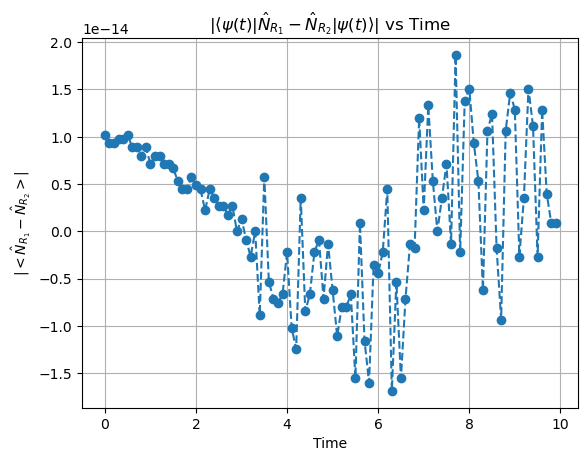

In [552]:
start_time = time.time()


# _, N_diff_exp = N1_minusN2_exp(params, phi = np.pi)
# print(f'N_diff_exp={N_diff_exp}')
t_list = np.arange(0, params['T'], params['tau']).round(1)
plt.plot(t_list, np.real(N_diff_exp), "--o")
plt.xlabel('Time')
plt.grid('True')
plt.ylabel(f'$|<\\hat{{N}}_{{R_1}} - \\hat{{N}}_{{R_2}}>|$')
plt.title(r'$ | \langle \psi(t) | \hat{N}_{R_1} - \hat{N}_{R_2} | \psi(t) \rangle | $ vs Time')


end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

# <font>Correlation Matrix Elements as a function of Time</font>

In [553]:
def correlations_matrix(params, **kwargs):
    '''
    Returns Correlation Matrix,
    kwargs: wfn [Required] - wavefunction which would be used to compute the Correlation matrix.
    '''
    I, annihOp = sp.identity(params['truncationParam_n']+1), annihilationOpMatrix(params)
    PM, createOp, lst = projectionMatrix(params), creationOpMatrix(params), [I for _ in range(params['N'])]
    wfn = kwargs['wfn']
    H = np.zeros((params['N'], params['N']), dtype = complex)
    for i in range(params['N']):
        for j in range(params['N']):
            if i == j:
                lst[i] = createOp@annihOp
            else:
                lst[i] = createOp
                lst[j] = annihOp
            HopOp = PM@reduce(sp.kron, lst)@PM.transpose()
            H[i, j] =  np.vdot(wfn, HopOp@wfn)
            lst[i], lst[j] = I, I
    return H

In [554]:
correl_matrix = correlations_matrix(params, wfn = psi_t[0])

D:\AnacondaFinal\anacondaInstall\envs\WalshPulseSeq\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [555]:
## Use it only once to initialize it.
mag, phase = [[] for _ in correl_matrix.flatten()], [[] for _ in correl_matrix.flatten()]

In [556]:
for i in range(len(psi_t)):
    correl_matrix = correlations_matrix(params, wfn = psi_t[i])
    
    k = 0
    for i, row in enumerate(correl_matrix):
        for j, val in enumerate(row):
            magnitude, argument = np.abs(val), np.angle(val)
            mag[k].append(magnitude)
            phase[k].append(argument)
            k+=1
    
print(mag)
print(phase)

[[0.8652853231570046, 0.8652907506243058, 0.8653747998560007, 0.8657577381503299, 0.8668478511421134, 0.8692595861208843, 0.873781007456492, 0.8812793904716731, 0.8925595591336785, 0.9082046964632924, 0.9284315710152129, 0.9529884472239758, 0.9811192193970613, 1.0116083288928461, 1.0429031619340605, 1.0732877391289564, 1.1010658152132704, 1.1247129177270927, 1.1429740633293246, 1.1549064440145027, 1.1598836828740424, 1.1575855691810557, 1.147994823119458, 1.1314125841507445, 1.108489725045879, 1.0802557790821843, 1.0481169551629919, 1.0137957900849393, 0.9792012876834011, 0.9462464948603835, 0.9166574149537441, 0.8918258233279925, 0.8727398177959959, 0.8599883373229376, 0.8538022722464078, 0.8540865278633878, 0.8604186781701926, 0.8720252834124331, 0.8877736139517535, 0.9062193792424267, 0.9257301852804888, 0.9446716994160402, 0.9616144918845273, 0.9755068526141448, 0.9857680854956699, 0.9922842404383562, 0.995322016202582, 0.9954015678483039, 0.9931746328728138, 0.9893399852481471, 0.

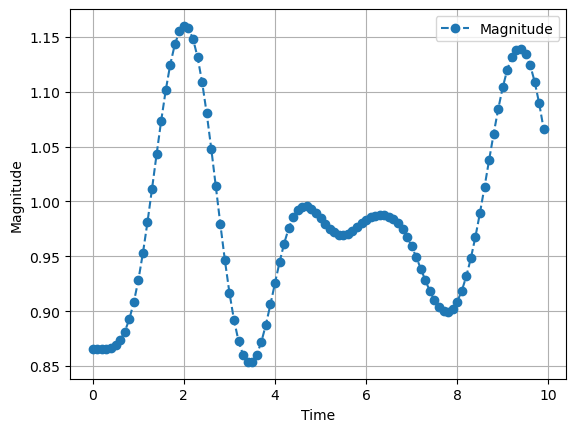

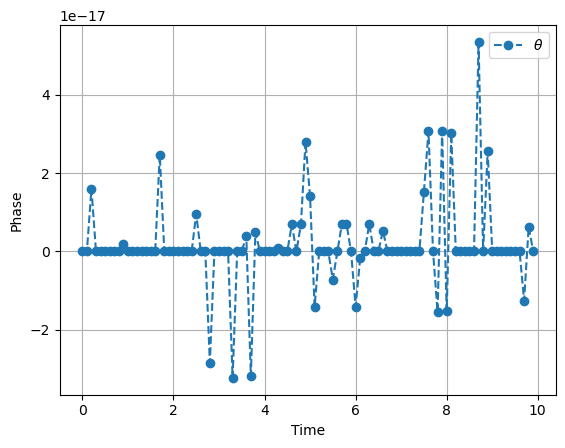

In [557]:
plt.plot(np.arange(0, params['T'], params['tau']), mag[0], "--o", label = r"Magnitude")
plt.ylabel("Magnitude")
plt.xlabel("Time")
plt.grid("True")
plt.legend()
plt.show()
plt.plot(np.arange(0, params['T'], params['tau']), phase[0], "--o", label = r"$\theta$")
plt.ylabel('Phase')
plt.xlabel("Time")
plt.grid("True")
plt.legend()
plt.show()
# len(mag[0])

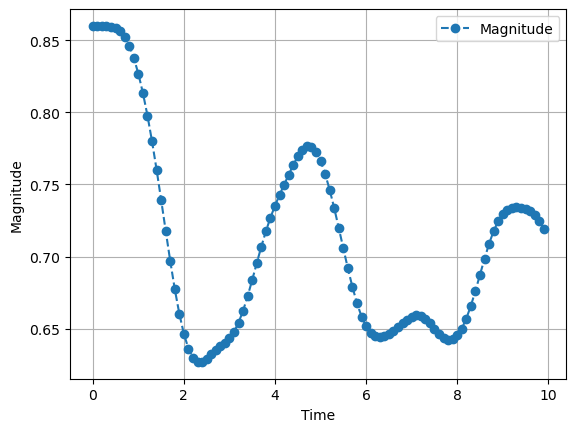

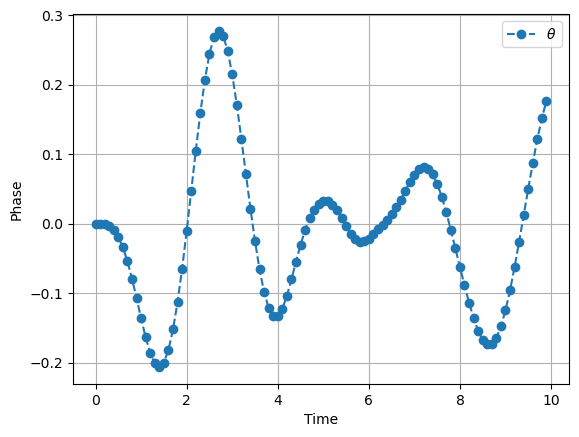

In [558]:
plt.plot(np.arange(0, params['T'], params['tau']), mag[1], "--o", label = r"Magnitude")
plt.ylabel("Magnitude")
plt.xlabel("Time")
plt.grid("True")
plt.legend()
plt.show()
plt.plot(np.arange(0, params['T'], params['tau']), phase[1], "--o", label = r"$\theta$")
plt.ylabel('Phase')
plt.xlabel("Time")
plt.grid("True")
plt.legend()
plt.show()
# len(mag[0])

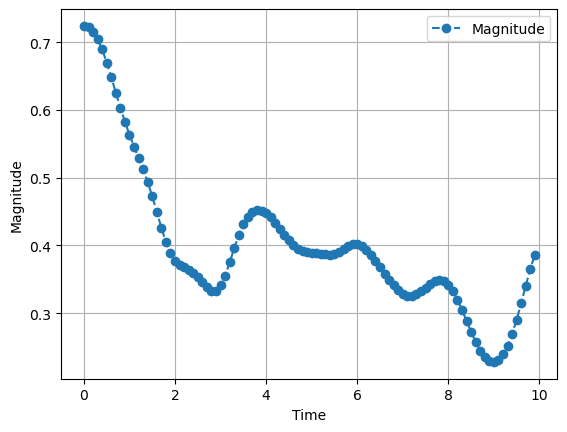

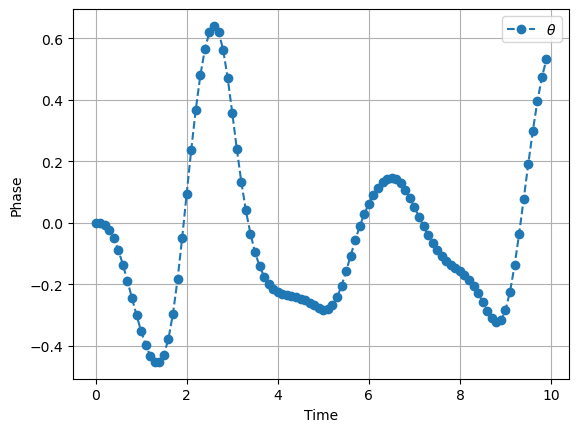

In [559]:
plt.plot(np.arange(0, params['T'], params['tau']), mag[2], "--o", label = r"Magnitude")
plt.ylabel("Magnitude")
plt.xlabel("Time")
plt.grid("True")
plt.legend()
plt.show()
plt.plot(np.arange(0, params['T'], params['tau']), phase[2], "--o" , label = r"$\theta$")
plt.ylabel('Phase')
plt.xlabel("Time")
plt.grid("True")
plt.legend()
plt.show()
# len(mag[0])

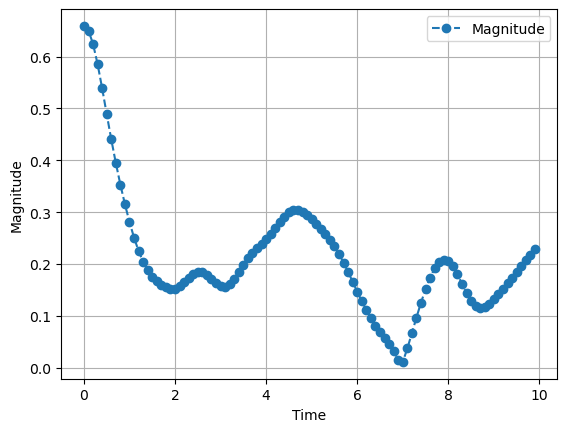

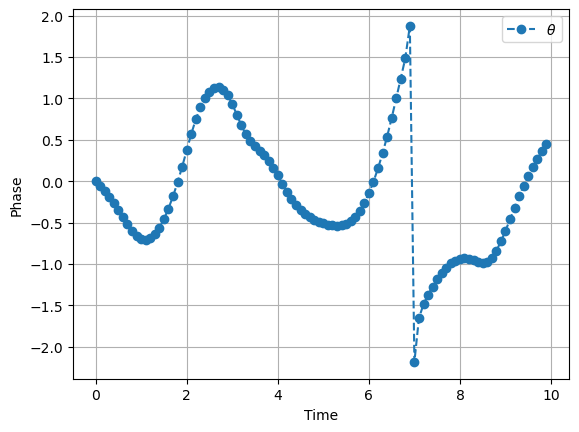

In [560]:
plt.plot(np.arange(0, params['T'], params['tau']), mag[3], "--o" , label = r"Magnitude")
plt.ylabel("Magnitude")
plt.xlabel("Time")
plt.grid("True")
plt.legend()
plt.show()
plt.plot(np.arange(0, params['T'], params['tau']), phase[3], "--o", label = r"$\theta$")
plt.ylabel('Phase')
plt.xlabel("Time")
plt.grid("True")
plt.legend()
plt.show()
# len(mag[0])

In [561]:
def correl_mag_phase(params, **kwargs):
    '''
    Returns plots of magnitude and phase of each Correlation Matrix element as a function of time.
    Args: params
    kwargs: list of psi_t [Required] - to introduce the time-dependence through wavefunction.
    '''
    fig, axs = plt.subplots(len(H.flatten()), 2, figsize=(14, 6))
    mag, phase = [], []
    for i in H:     
        mag.append(np.abs(i))
        phase.append(np.angle(i))
        im = axs[0].imshow(H, cmap='seismic', vmin=-np.abs(H).max(), vmax=np.abs(H).max())
        axs[0].set_xlabel('Site i')
        axs[0].set_ylabel('Site j')
        axs[0].set_title(f'Boson Correlation $\\langle b_i^\\dagger b_j \\rangle$')
        fig.colorbar(im, ax=axs[0])
    plt.show()
    pass

# <font>Correlation Matrix</font>

In [562]:
def correlations(params, **kwargs):
    '''
    Returns plots of Expectation Value of Hopping Ops,
    Correlation between particle at the center of lattice and
    the remaining sites.
    kwargs: wfn [Required] - wavefunction which would be used to compute the Correlation matrix.
    '''
    I, annihOp = sp.identity(params['truncationParam_n']+1), annihilationOpMatrix(params)
    PM, createOp, lst = projectionMatrix(params), creationOpMatrix(params), [I for _ in range(params['N'])]
    wfn = kwargs['wfn']
    H = np.zeros((params['N'], params['N']), dtype = complex)
    for i in range(params['N']):
        for j in range(params['N']):
            if i == j:
                lst[i] = createOp@annihOp
            else:
                lst[i] = createOp
                lst[j] = annihOp
            HopOp = PM@reduce(sp.kron, lst)@PM.transpose()
            H[i, j] =  np.vdot(wfn, HopOp@wfn)
            lst[i], lst[j] = I, I
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    H = np.real(H)
    im = axs[0].imshow(H, cmap='seismic', vmin=-np.abs(H).max(), vmax=np.abs(H).max())
    axs[0].set_xlabel('Site i')
    axs[0].set_ylabel('Site j')
    axs[0].set_title(f'Boson Correlation $\\langle b_i^\\dagger b_j \\rangle$')
    fig.colorbar(im, ax=axs[0])

    # Second subplot for the correlation plot
    middle_index = (params['N'] - 1) // 2
    correlation_rate = H[middle_index, :]
    axs[1].semilogy(list(range(params['N'])), correlation_rate)
    axs[1].set_xlabel('Site i')
    axs[1].set_ylabel('Correlation')
    axs[1].set_title(f'Correlation between particle at site i={middle_index} and remaining sites')
    axs[1].grid(True)
    plt.show()
    pass

D:\AnacondaFinal\anacondaInstall\envs\WalshPulseSeq\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


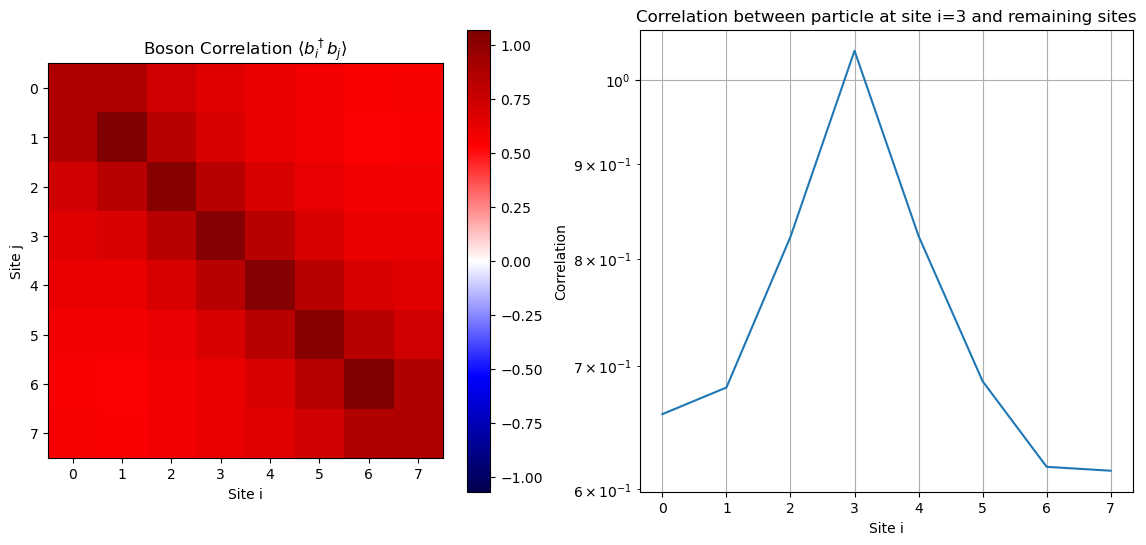

In [563]:
correlations(params, wfn = eigenvec)

D:\AnacondaFinal\anacondaInstall\envs\WalshPulseSeq\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


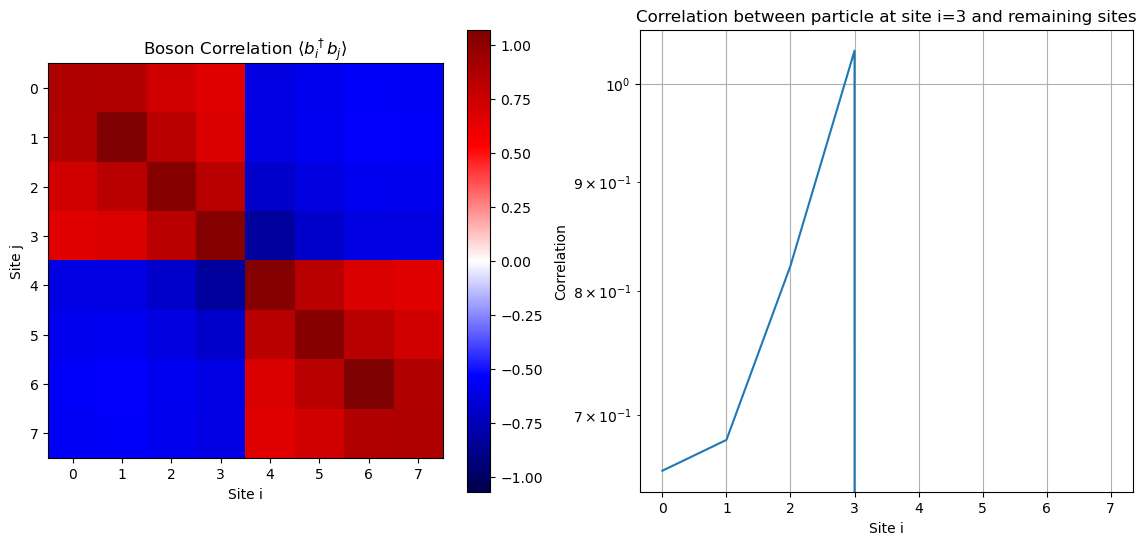

In [564]:
correlations(params, wfn = psi_t[0])

In [577]:
# correlations(params, wfn = psi_prime)

D:\AnacondaFinal\anacondaInstall\envs\WalshPulseSeq\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


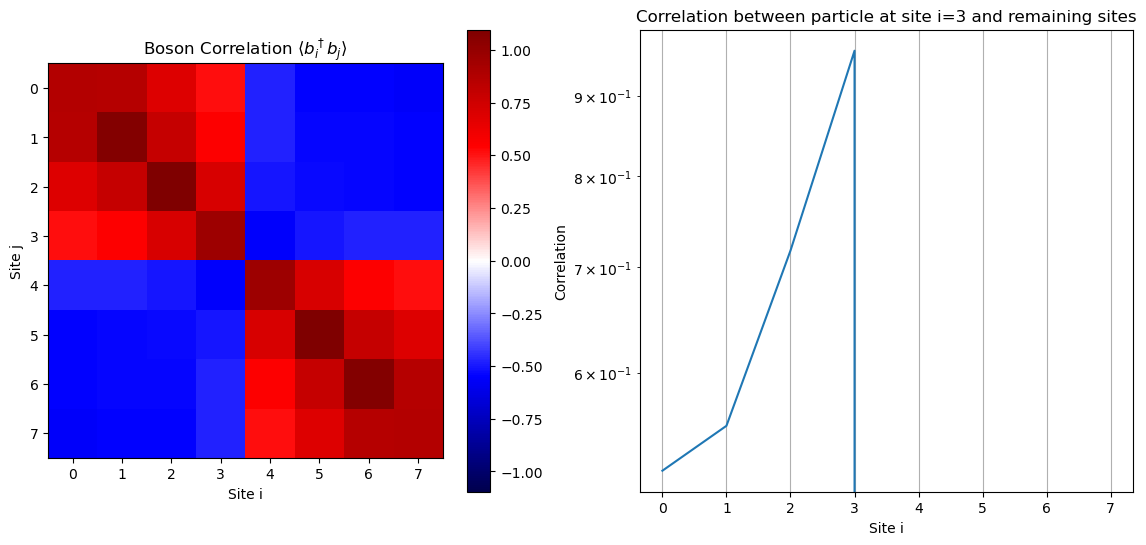

In [566]:
correlations(params, wfn = psi_t[4])

D:\AnacondaFinal\anacondaInstall\envs\WalshPulseSeq\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


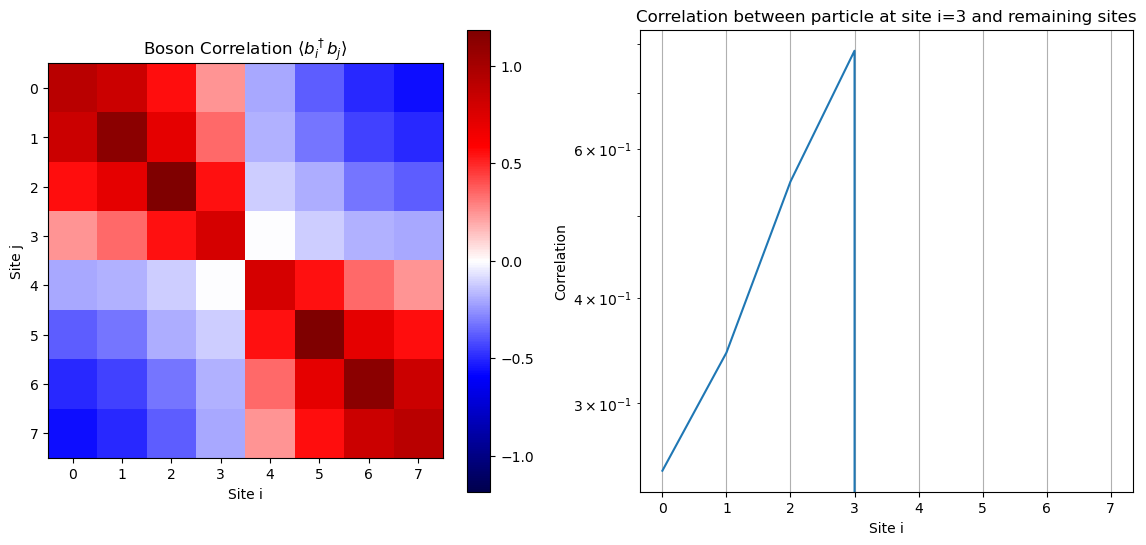

In [578]:
correlations(params, wfn = psi_t[9])

D:\AnacondaFinal\anacondaInstall\envs\WalshPulseSeq\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


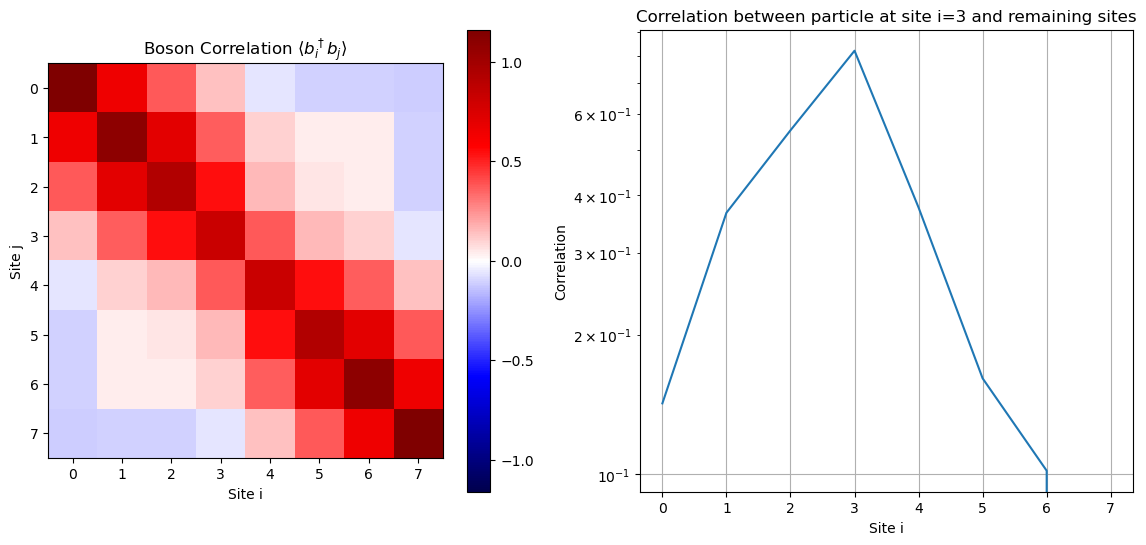

In [579]:
correlations(params, wfn = psi_t[20])

D:\AnacondaFinal\anacondaInstall\envs\WalshPulseSeq\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


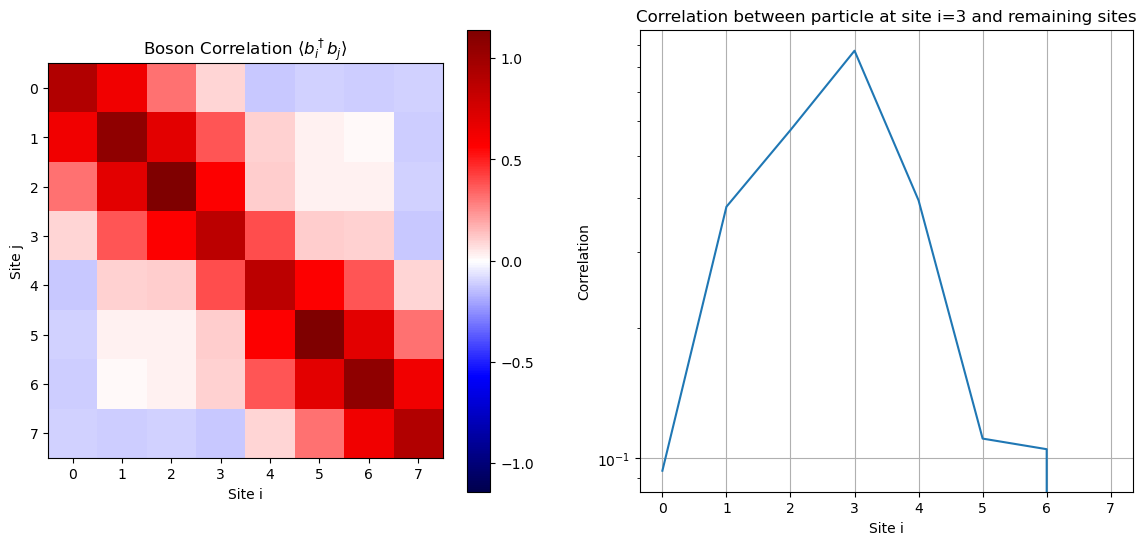

In [580]:
correlations(params, wfn = psi_t[30])

D:\AnacondaFinal\anacondaInstall\envs\WalshPulseSeq\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


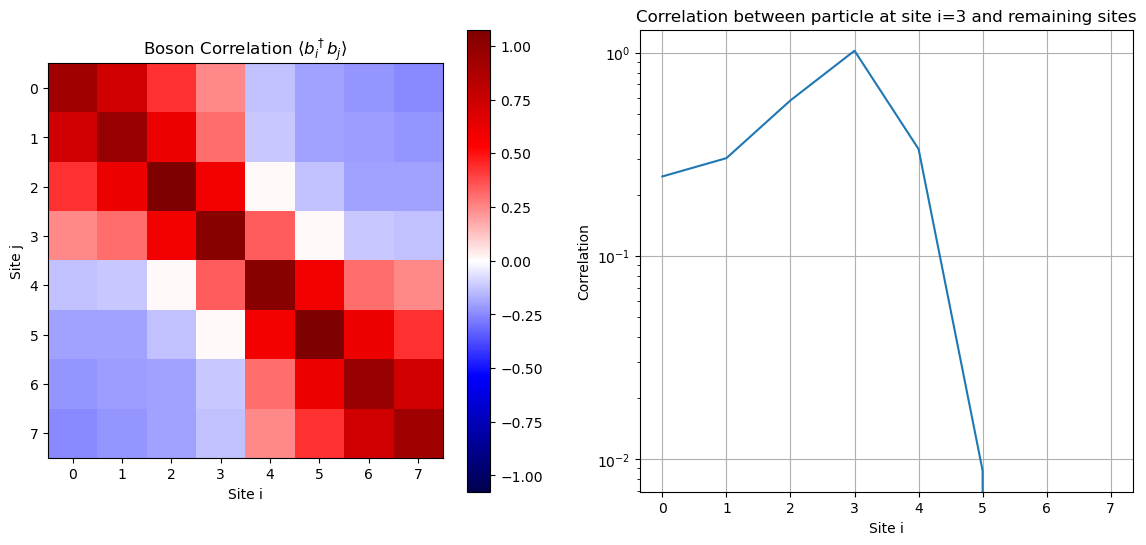

In [581]:
correlations(params, wfn = psi_t[40])

D:\AnacondaFinal\anacondaInstall\envs\WalshPulseSeq\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


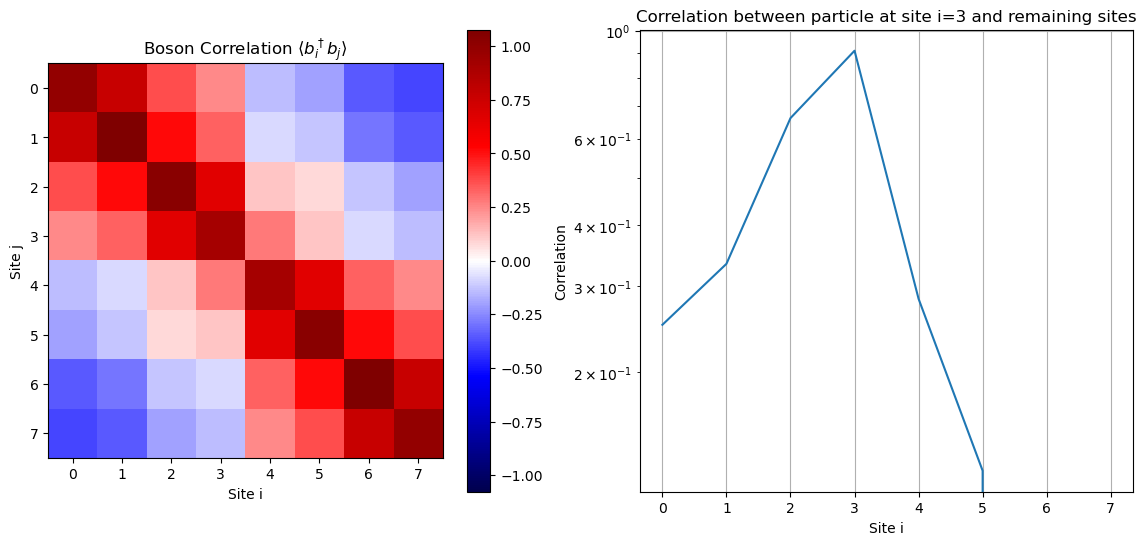

In [582]:
correlations(params, wfn = psi_t[50])

D:\AnacondaFinal\anacondaInstall\envs\WalshPulseSeq\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


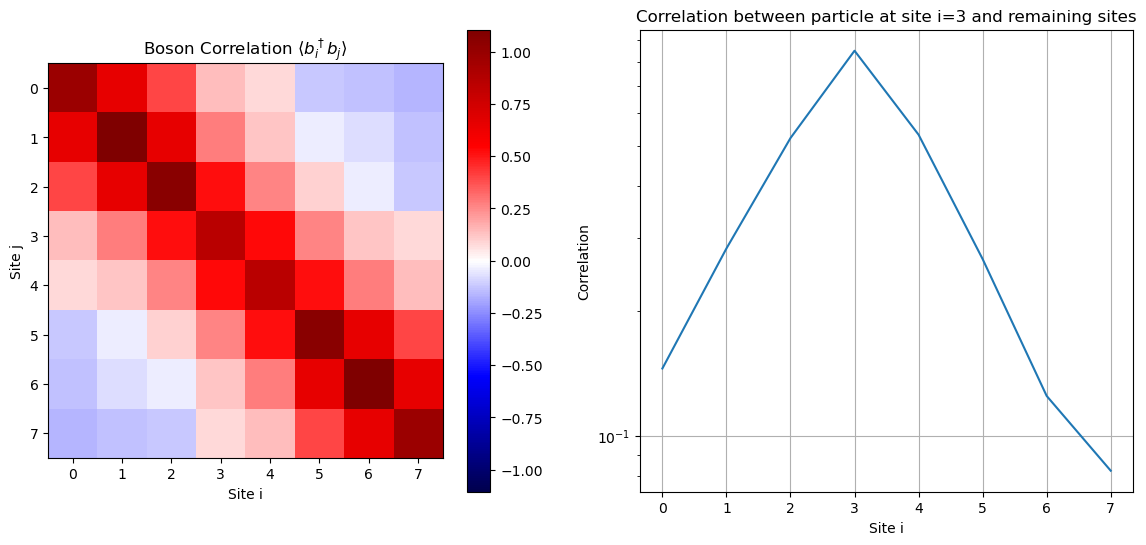

In [583]:
correlations(params, wfn = psi_t[60])

D:\AnacondaFinal\anacondaInstall\envs\WalshPulseSeq\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


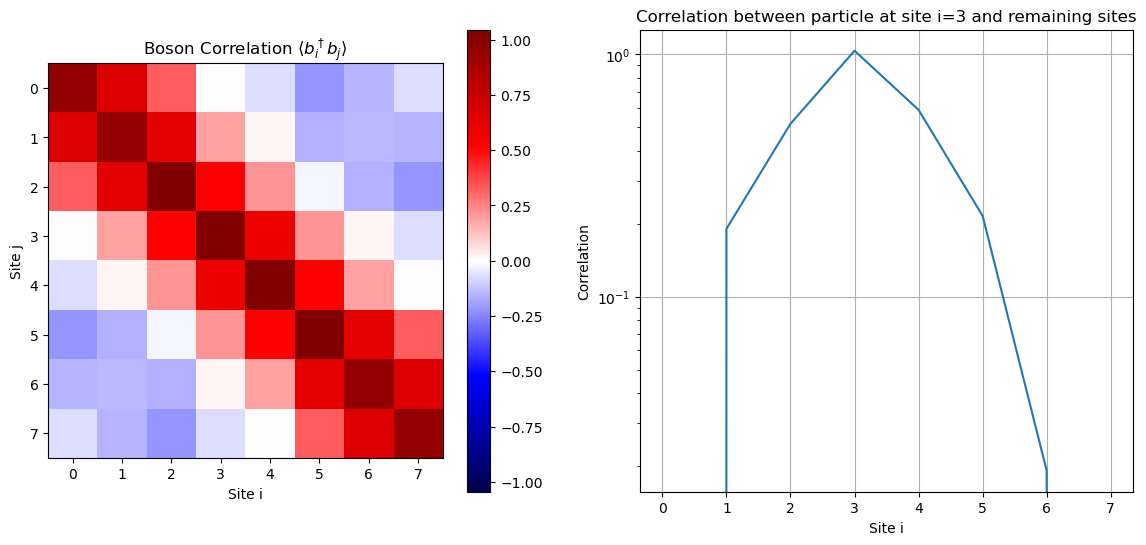

In [584]:
correlations(params, wfn = psi_t[70])

D:\AnacondaFinal\anacondaInstall\envs\WalshPulseSeq\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


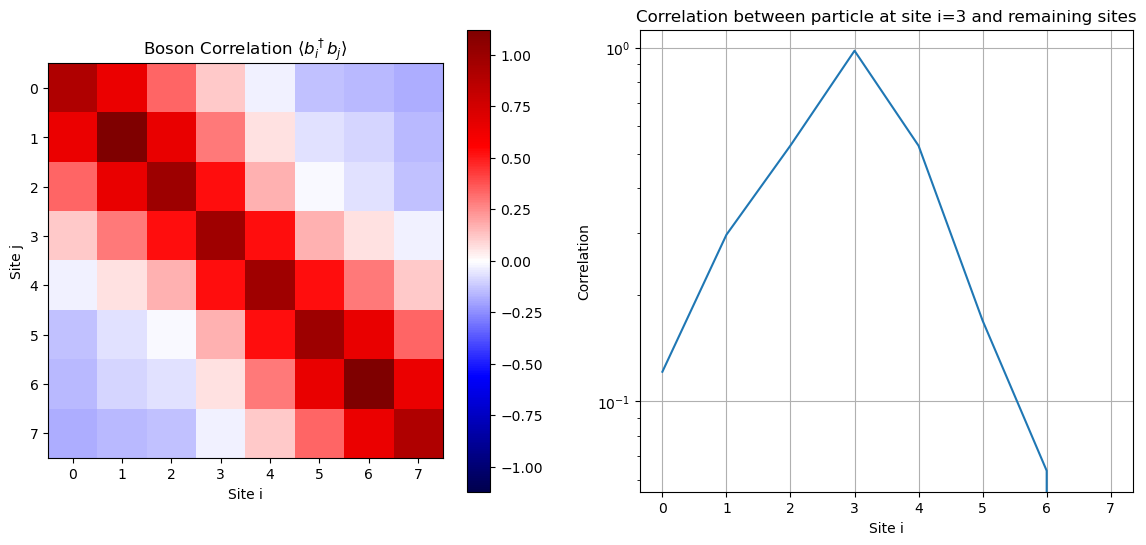

In [585]:
correlations(params, wfn = psi_t[80])

D:\AnacondaFinal\anacondaInstall\envs\WalshPulseSeq\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


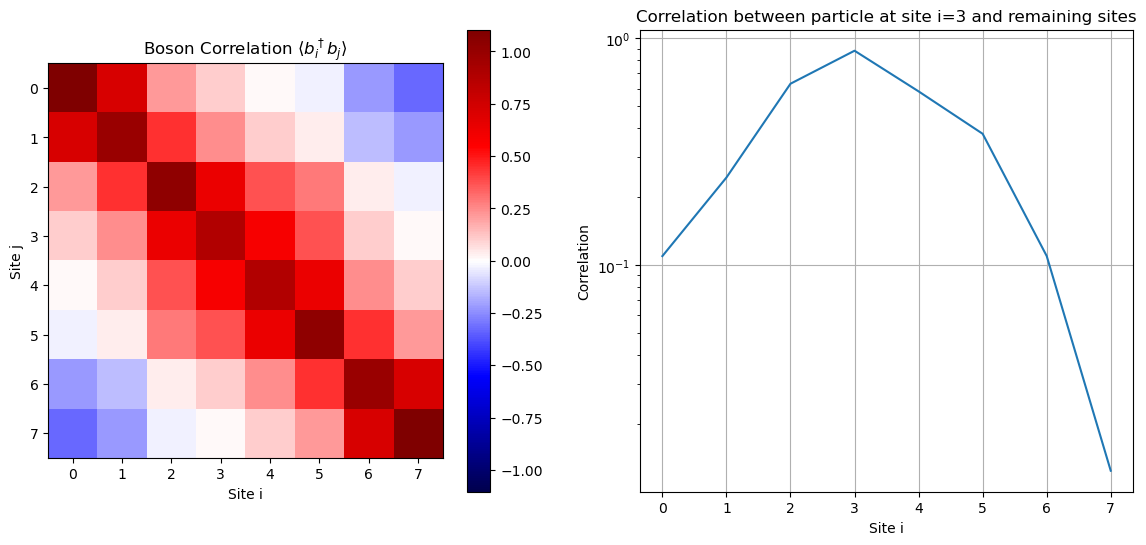

In [586]:
correlations(params, wfn = psi_t[90])

D:\AnacondaFinal\anacondaInstall\envs\WalshPulseSeq\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


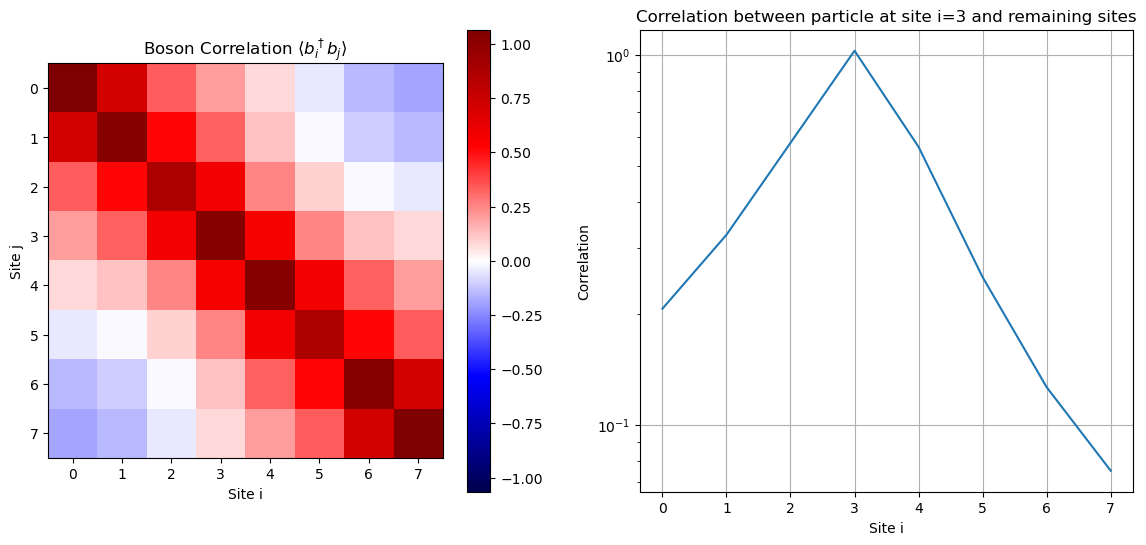

In [587]:
correlations(params, wfn = psi_t[99])

# <font>Density</font>

In [54]:
def density_eachSite(params, **kwargs):
    '''
    Returns plot of density of particles at each site.
    kwargs: wfn [Required] - wavefunction for which density at each site must be calculated.
    '''
    PM, expval_nOp = projectionMatrix(params), []
    wfn = kwargs['wfn']
    for i in range(params['N']):
        NumOp, NumOp_2 = numOpMatrix(params, i)
        nOp = PM@NumOp@PM.transpose()
        expval_nOp.append(np.vdot(wfn, nOp@wfn))
    plt.plot(list(range(params['N'])), np.real(expval_nOp), marker = "o")
    plt.ylabel('Occupation')
    plt.xlabel('Site Index')
    plt.title(f'Number of Particles at each site')
    plt.show()


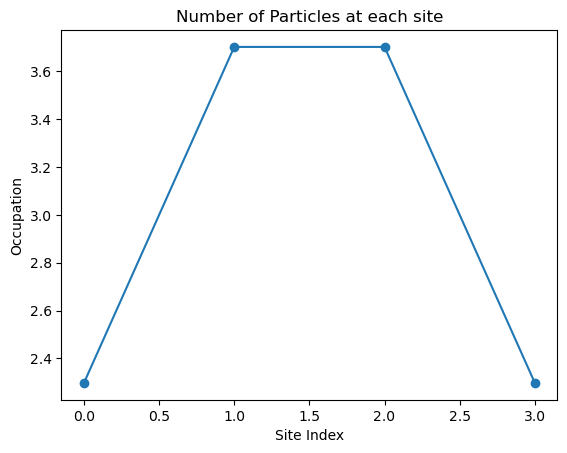

In [55]:
density_eachSite(params, wfn = eigenvec)

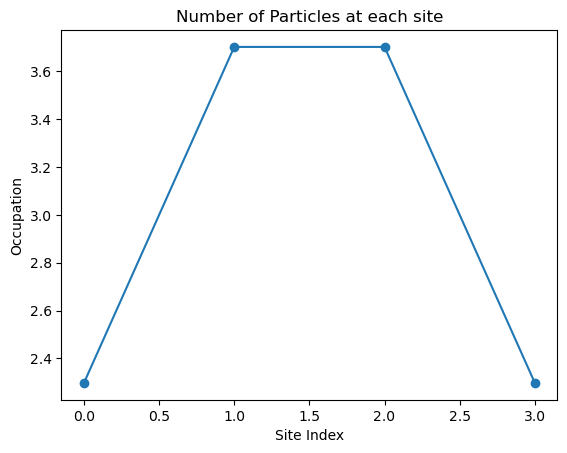

In [56]:
density_eachSite(params, wfn = psi_prime)

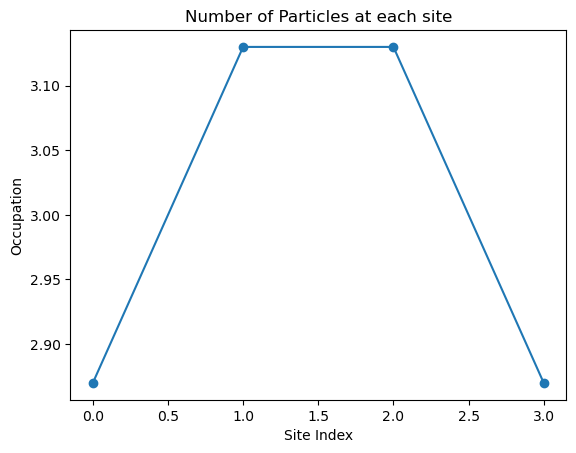

In [57]:
density_eachSite(params, wfn = psi_t[4])

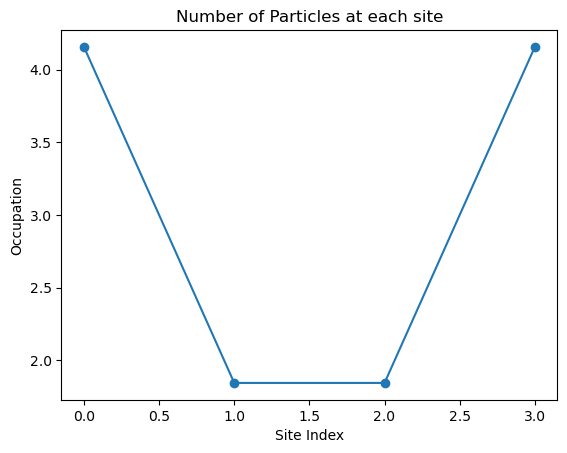

In [58]:
density_eachSite(params, wfn = psi_t[9])

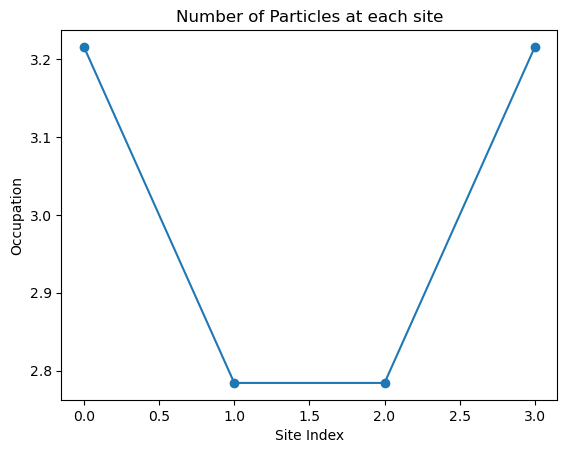

In [59]:
density_eachSite(params, wfn = psi_t[20])

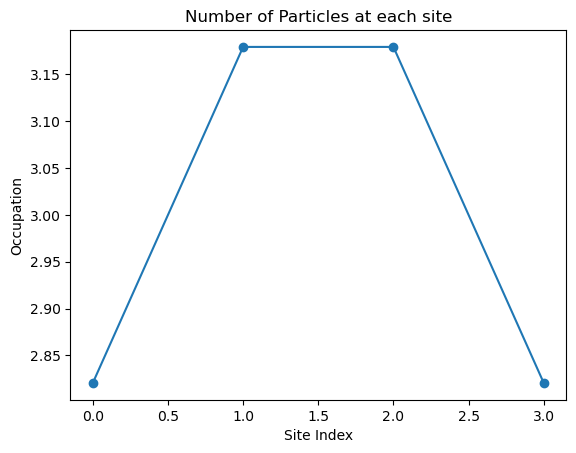

In [60]:
density_eachSite(params, wfn = psi_t[30])

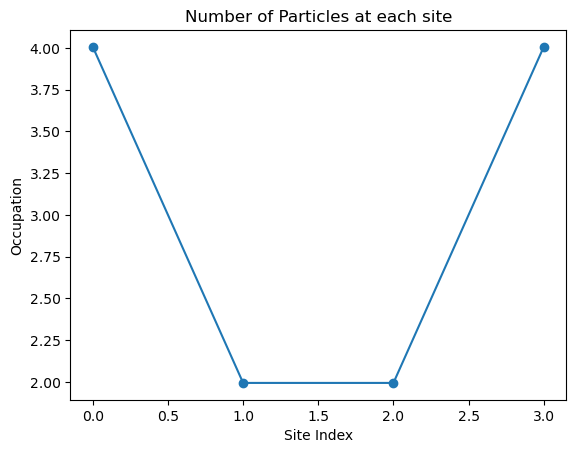

In [61]:
density_eachSite(params, wfn = psi_t[40])

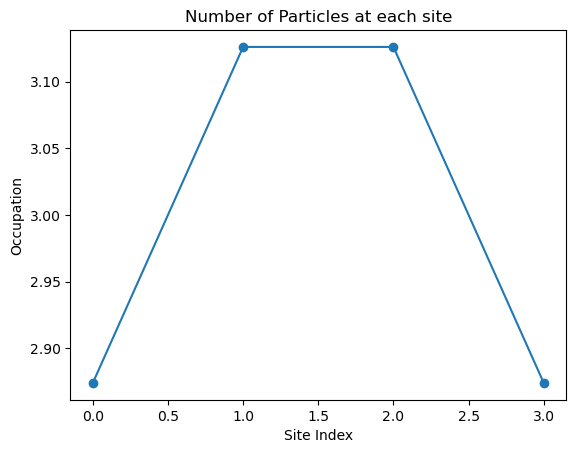

In [62]:
density_eachSite(params, wfn = psi_t[50])

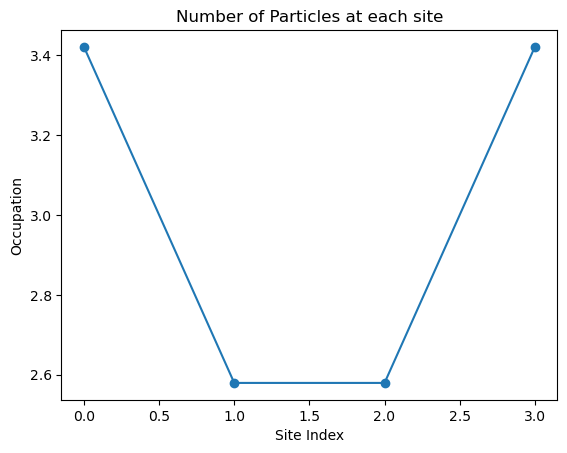

In [63]:
density_eachSite(params, wfn = psi_t[60])

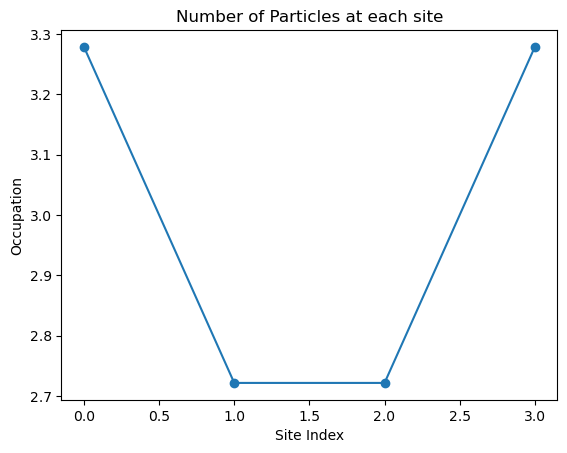

In [64]:
density_eachSite(params, wfn = psi_t[70])

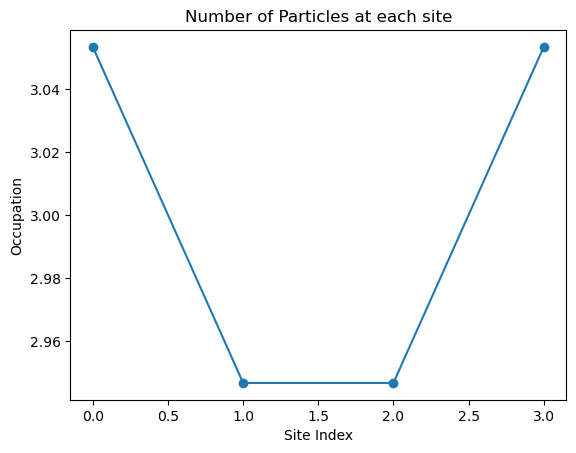

In [65]:
density_eachSite(params, wfn = psi_t[80])

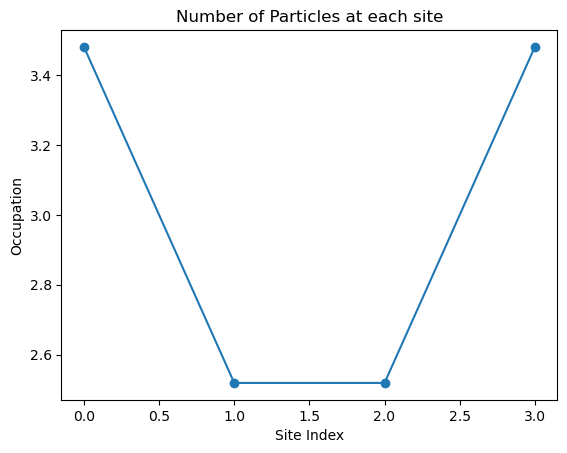

In [66]:
density_eachSite(params, wfn = psi_t[90])

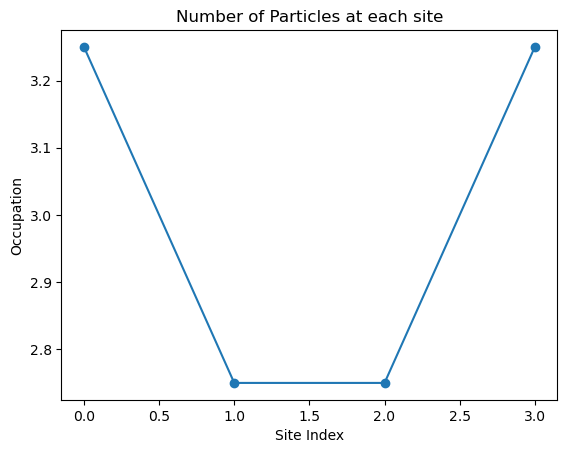

In [67]:
density_eachSite(params, wfn = psi_t[99])